In [1]:
%%capture

%matplotlib widget

from pathlib import Path
import pickle

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("matplotlib_style.txt")

import numpy as np
import pandas as pd

np.random.seed(42)

import sklearn
from openTSNE import TSNE
from rnanorm import CTF  # pip install rnanorm
from umap import UMAP

In [2]:
import jupyter_black
jupyter_black.load(line_length=79)

# Data

We are going to use the multimodal data from the paper Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). In particular, you will work with transcriptomics and electrophysiological data. From the transcriptomics gene counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out for the project.

In [3]:
data_path = Path("../data")

## Import

### Meta data

In [4]:
# META DATA

meta = pd.read_csv(data_path / "m1_patchseq_meta_data.csv", sep="\t")

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [
        c if c[-1] != "+" and c[-1] != "-" else c[:-1]
        for c in meta["Cre"].values
    ]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [
        np.unique(meta["Date"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse age"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse"].values[sliceids == s]).size == 1
        for s in sliceids
    ]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


### Transcriptomic data

In [5]:
# READ COUNTS

data_exons = pd.read_csv(
    data_path / "m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
exonCounts = data_exons.values.transpose()

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

print("Count matrix shape (exon):  ", exonCounts.shape)

Count matrix shape (exon):   (1329, 42466)


In [6]:
data_exons

,20171204_sample_2,20171204_sample_4,20171204_sample_5,20171204_sample_6,20171207_sample_1,20171207_sample_2,20171207_sample_6,20171207_sample_7,20171219_sample_1,20171219_sample_2,...,20191114_sample_9,20200106_sample_1,20200106_sample_4,20200106_sample_5,20200106_sample_6,20200225_sample_2,20200225_sample_5,20200316_sample_1,20200316_sample_2,20200316_sample_3
0610005C13Rik,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
0610006L08Rik,0,0,0,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610009B22Rik,0,68,1291,0,0,0,227,0,7,10,...,0,271,0,0,0,0,138,0,78,89
0610009E02Rik,0,0,0,0,30,80,205,0,0,14,...,0,0,0,0,0,0,1,0,0,0
0610009L18Rik,0,0,0,0,0,99,0,380,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-TSaga9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# GENE LENGTH

data = pd.read_csv(data_path / "gene_lengths.txt")
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values
intronLengths = data["intron_bp"].values
print(exonLengths)

[3583 2128  998 ...  119  107  109]


### Cluster colors

In [8]:
cluster_colors = np.load(data_path / "cluster_colors.npy")

In [9]:
cluster_colors.shape

(1329,)

In [10]:
rna_type = np.load(data_path / "rna_type.npy", allow_pickle=True)

In [11]:
rna_type.shape

(1329,)

In [12]:
pickle_in = open(data_path / "dict_rna_type_colors.pkl", "rb")
dict_rna_type_colors = pickle.load(pickle_in)

In [13]:
len(dict_rna_type_colors)

88

### Electrophysiological features

In [14]:
# EPHYS DATA

ephysData = pd.read_csv(data_path / "m1_patchseq_ephys_features.csv")
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [
        names2ephys[c] if c in names2ephys else ephysData[0] * np.nan
        for c in cells
    ]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


In [15]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]
features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData
print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)

X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)

(1329, 29)
(1320, 17)


In [16]:
np.sum(np.isnan(ephysData_filtered))

0

# Research questions to investigate

**1) Inspect the data computing different statistics.** Keep in mind that the data is read counts, not UMI, so it is not supposed to follow a Poisson distribution.

**2) Normalize and transform the data.** There are several ways of normalizing the data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization.

**3) Two-dimensional visualization.** Try different methods (t-SNE, UMAP) / parameters (exagg., perplex.) for visualizations. Compare them using quantitative metrics (e.g., distance correlation, kNN accuracy/recall in high-dim vs. two-dim). Think about also using the electrophysiological features for different visualizations.

**4) Clustering.** Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2) and S (set of important genes). Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation in between electrophysiological features and genes/PCs.** Find correlations and a way of visualizing them.
    

## 1) Inspecting Data

In [17]:
# check for nan
assert np.isnan(exonCounts).sum() == 0

In [18]:
# Kick out all genes with all counts = 0
genes = genes[exonCounts.sum(axis=0) > 0]
exonLengths = exonLengths[exonCounts.sum(axis=0) > 0]
exonCounts = exonCounts[:, exonCounts.sum(axis=0) > 0]

# check if they keep same size
assert genes.size == exonCounts.shape[1]

In [19]:
# Compute the average expression for each gene
avg_counts = np.mean(exonCounts, axis=0)

# Compute the fraction of zeros for each gene
zero_fraction = np.sum(exonCounts == 0, axis=0) / exonCounts.shape[0]

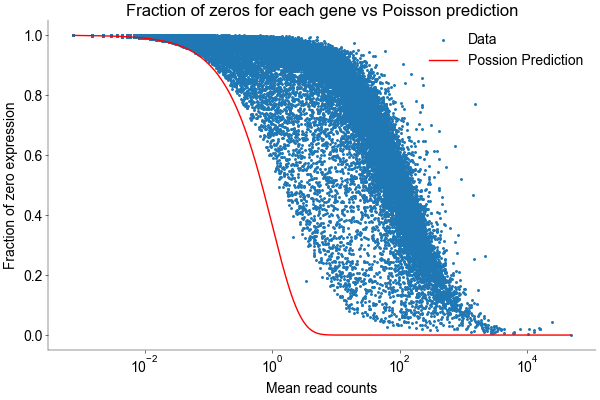

In [20]:
# Compute the Poisson prediction

Poiss_predicted_fraction = np.exp(-np.unique(avg_counts))


# Plot

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(avg_counts, zero_fraction, s=5, label="Data")
ax.plot(
    np.unique(avg_counts),
    Poiss_predicted_fraction,
    c="red",
    label="Possion Prediction",
)

ax.set_ylabel("Fraction of zero expression")
ax.set_xlabel("Mean read counts")
ax.set_title("Fraction of zeros for each gene vs Poisson prediction")

ax.legend()
ax.set_xscale("log")
# add plot

Chen, W., Li, Y., Easton, J. et al. UMI-count modeling and differential expression analysis for single-cell RNA sequencing. Genome Biol 19, 70 (2018). https://doi.org/10.1186/s13059-018-1438-9

Jiang, R., Sun, T., Song, D. et al. Statistics or biology: the zero-inflation controversy about scRNA-seq data. Genome Biol 23, 31 (2022). https://doi.org/10.1186/s13059-022-02601-


As we were expecting, the read counts seem to deviate significantly from the Poisson model. First observation is that the fraction of zeroes observed is consistently higher than a poisson model would predict. Another one is a visually noticeable variability of the mean read counts for a same fraction of zeros, resulting in a wide curve (very different from what was observed in the dataset of CodingLab 7). One of the main factors underlying this deviances is probably the so-called amplification bias. Since the amount of transcripts collected from single cells is very small, cDNA amplification is necessary for the construction of the library. Nevertheless, this amplification is also a stochastic process, resulting in distortions (e.g., the same amount of a specific transcript was captured for two different cells. But in one of them, the cDNA amplification lead to a higher amount of read counts) (Chen et al. 2018). The UMI techniques try to mitigate this bias, by tagging the transcripts befor amplification.

Another point raised by Chen et al. (2018) is the higher number of dropout events in single cell sequencing (missing values, due to biological and technical stochasticities). The authors argue that accounting for these kind of event is relevant for read counts, but not much for UMI. Apparently, there is a big discussion in the scRNA-seq field if models should include zero inflations (to correct for the dropout events) or not (Jiang et al. 2022). 

### Some statistics

In [21]:
depth = np.sum(exonCounts, axis=1)
genes_detected = np.sum(exonCounts != 0, axis=1)

# Basic statistics (same reported in GitHub https://github.com/berenslab/mini-atlas/blob/master/code/ttype-assignment.ipynb)
print(
    "Depth: median {:.0f}, mean+-STD log10: {:.1f}+-{:.1f}".format(
        np.median(depth), np.mean(np.log10(depth)), np.std(np.log10(depth))
    )
)


print(
    "Genes detected per cell: median {:.0f}, mean+-STD: {:.0f}+-{:.0f}".format(
        np.mean(genes_detected),
        np.mean(genes_detected),
        np.std(genes_detected),
    )
)

Depth: median 1281492, mean+-STD log10: 6.0+-0.6
Genes detected per cell: median 6766, mean+-STD: 6766+-2742


Text(0.5, 1.0, 'Sequencing depth per cell')

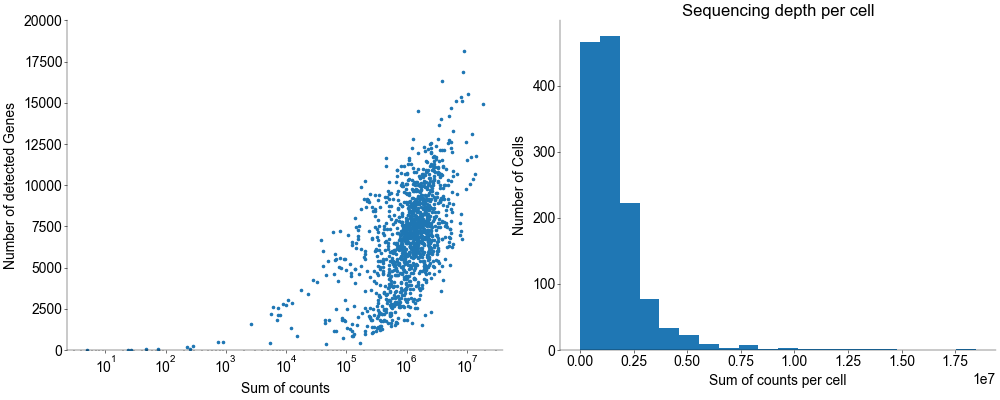

In [22]:
# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot number of detected genes vs number of counts
axs[0].scatter(depth, genes_detected, s=10)
axs[0].set_xscale("log")
axs[0].set_ylim(0, 20000)
axs[0].set_ylabel("Number of detected Genes")
axs[0].set_xlabel("Sum of counts")
axs[0].set_title("")

# Plot histogram of sequencing depths (1 pt)
axs[1].hist(depth, bins=20)
axs[1].set_xlabel("Sum of counts per cell")
axs[1].set_ylabel("Number of Cells")
axs[1].set_title("Sequencing depth per cell")

#### Mean-Variance analysis

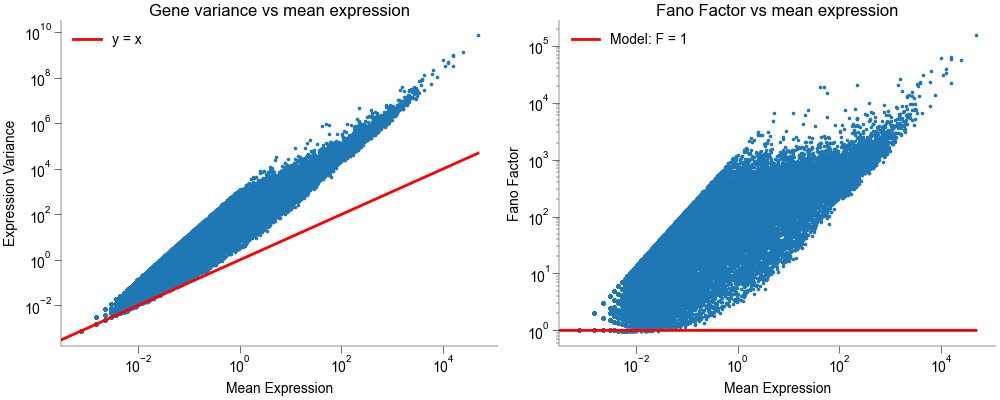

In [23]:
# Compute the variance of the expression counts of each gene
var_counts = np.var(exonCounts, axis=0)

# Fano factor
Fano = var_counts / avg_counts

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].scatter(avg_counts, var_counts, s=10)
axs[0].plot(
    np.arange(0, np.max(avg_counts), 1),
    np.arange(0, np.max(avg_counts), 1),
    color="r",
    linewidth=2,
    label="y = x",
)

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel("Mean Expression")
axs[0].set_ylabel("Expression Variance")
axs[0].set_title("Gene variance vs mean expression")
axs[0].tick_params(which="minor", length=1, color="k")
axs[0].tick_params(which="major", length=5, color="k")
axs[0].legend()

# Fano Plot
axs[1].scatter(avg_counts, Fano, s=10)
axs[1].plot(
    np.arange(0, np.max(avg_counts), 1),
    np.ones(np.arange(0, np.max(avg_counts), 1).size),
    color="r",
    linewidth=2,
    label="Model: F = 1",
)
axs[1].set_xlabel("Mean Expression")
axs[1].set_ylabel("Fano Factor")
axs[1].set_title("Fano Factor vs mean expression")
# axs[1].set_ylim(0.4, 200)
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].tick_params(which="minor", length=2, color="k")
axs[1].tick_params(which="major", length=5, color="k")

axs[1].legend()

In [24]:
def geneSelection(
    data,
    threshold=0,
    atleast=10,
    yoffset=0.02,
    xoffset=5,
    decay=1.5,
    n=None,
    plot=True,
    markers=None,
    genes=None,
    figsize=(6, 3.5),
    markeroffsets=None,
    labelsize=10,
    alpha=1,
):
    zeroRate = 1 - np.mean(data > threshold, axis=0)
    meanExpr = np.zeros_like(zeroRate) * np.nan
    detected = zeroRate < 1
    mask = data[:, detected] > threshold
    logs = np.zeros_like(data[:, detected]) * np.nan
    logs[mask] = np.log2(data[:, detected][mask])
    meanExpr[detected] = np.nanmean(logs, axis=0)

    lowDetection = (
        np.array(np.sum(data > threshold, axis=0)).squeeze() < atleast
    )
    zeroRate[lowDetection] = np.nan
    meanExpr[lowDetection] = np.nan

    if n is not None:
        up = 10
        low = 0
        for t in range(100):
            nonan = ~np.isnan(zeroRate)
            selected = np.zeros_like(zeroRate).astype(bool)
            selected[nonan] = (
                zeroRate[nonan]
                > np.exp(-decay * (meanExpr[nonan] - xoffset)) + yoffset
            )
            if np.sum(selected) == n:
                break
            elif np.sum(selected) < n:
                up = xoffset
                xoffset = (xoffset + low) / 2
            else:
                low = xoffset
                xoffset = (xoffset + up) / 2
        print("Chosen offset: {:.2f}".format(xoffset))
    else:
        nonan = ~np.isnan(zeroRate)
        selected = np.zeros_like(zeroRate).astype(bool)
        selected[nonan] = (
            zeroRate[nonan]
            > np.exp(-decay * (meanExpr[nonan] - xoffset)) + yoffset
        )

    if plot:
        if figsize is not None:
            plt.figure(figsize=figsize)
        plt.ylim([0, 1])
        if threshold > 0:
            plt.xlim([np.log2(threshold), np.ceil(np.nanmax(meanExpr))])
        else:
            plt.xlim([0, np.ceil(np.nanmax(meanExpr))])
        x = np.arange(plt.xlim()[0], plt.xlim()[1] + 0.1, 0.1)
        y = np.exp(-decay * (x - xoffset)) + yoffset
        if decay == 1:
            plt.text(
                0.4,
                0.2,
                "{} genes selected\ny = exp(-x+{:.2f})+{:.2f}".format(
                    np.sum(selected), xoffset, yoffset
                ),
                color="k",
                fontsize=labelsize,
                transform=plt.gca().transAxes,
            )
        else:
            plt.text(
                0.4,
                0.2,
                "{} genes selected\ny = exp(-{:.1f}*(x-{:.2f}))+{:.2f}".format(
                    np.sum(selected), decay, xoffset, yoffset
                ),
                color="k",
                fontsize=labelsize,
                transform=plt.gca().transAxes,
            )

        plt.plot(x, y, color=sns.color_palette()[1], linewidth=2)
        xy = np.concatenate(
            (
                np.concatenate((x[:, None], y[:, None]), axis=1),
                np.array([[plt.xlim()[1], 1]]),
            )
        )
        t = matplotlib.patches.Polygon(
            xy, color=sns.color_palette()[1], alpha=0.4
        )
        plt.gca().add_patch(t)

        plt.scatter(meanExpr, zeroRate, s=1, alpha=alpha, rasterized=True)
        if threshold == 0:
            plt.xlabel("Mean log2 nonzero expression")
            plt.ylabel("Frequency of zero expression")
        else:
            plt.xlabel("Mean log2 nonzero expression")
            plt.ylabel("Frequency of near-zero expression")
        plt.tight_layout()

        if markers is not None and genes is not None:
            if markeroffsets is None:
                markeroffsets = [(0, 0) for g in markers]
            for num, g in enumerate(markers):
                i = np.where(genes == g)[0]
                plt.scatter(meanExpr[i], zeroRate[i], s=10, color="k")
                dx, dy = markeroffsets[num]
                plt.text(
                    meanExpr[i] + dx + 0.1,
                    zeroRate[i] + dy,
                    g,
                    color="k",
                    fontsize=labelsize,
                )
        plt.show()
    return selected

Chosen offset: 7.64


/tmp/ipykernel_100414/336102694.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


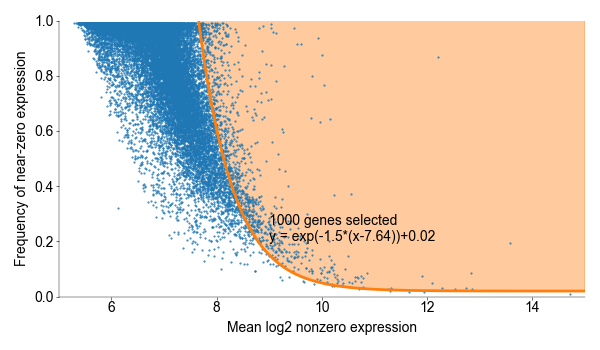

1000


In [25]:
genesForRRR = geneSelection(
    exonCounts, n=1000, threshold=32, decay=1.5, yoffset=0.02
)
print(np.sum(genesForRRR))

## Normalization and Transformation

### CTF normalization

Write about the different methods. In blog they suggest one for single cell sequencing, but didnt find python implementation. Took CTF from another paper, which claimed it is more robust (https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02568-9). Method is implemented in library (https://pypi.org/project/rnanorm/)



In [26]:
print(pd.DataFrame(exonCounts).shape)
CTF_exon_counts = (
    CTF()
    .set_output(transform="pandas")
    .fit_transform(pd.DataFrame(exonCounts))
)
CTF_exon_counts = CTF_exon_counts.values

(1329, 42197)


/home/izumigodai/anaconda3/envs/datasci/lib/python3.11/site-packages/rnanorm/methods/between_sample.py:93: RuntimeWarning: divide by zero encountered in divide
  return factors / self.geometric_mean_
/home/izumigodai/anaconda3/envs/datasci/lib/python3.11/site-packages/rnanorm/methods/between_sample.py:93: RuntimeWarning: invalid value encountered in divide
  return factors / self.geometric_mean_


In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
log_CTF_exon_counts = np.log2(CTF_exon_counts + 1)
axs[0].scatter(
    np.mean(log_CTF_exon_counts, axis=0),
    np.var(log_CTF_exon_counts, axis=0),
    s=10,
)
axs[0].plot(
    np.arange(0, np.max(np.mean(log_CTF_exon_counts, axis=0)), 1),
    np.arange(0, np.max(np.mean(log_CTF_exon_counts, axis=0)), 1),
    color="r",
    linewidth=2,
    label="y = x",
)

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel("Mean Expression")
axs[0].set_ylabel("Expression Variance")
axs[0].set_title("Gene variance vs mean expression")
axs[0].tick_params(which="minor", length=1, color="k")
axs[0].tick_params(which="major", length=5, color="k")
axs[0].legend()

# Fano Plot
axs[1].scatter(
    np.mean(log_CTF_exon_counts, axis=0),
    np.var(log_CTF_exon_counts, axis=0) / np.mean(log_CTF_exon_counts, axis=0),
    s=10,
)
axs[1].plot(
    np.arange(0, np.max(np.mean(log_CTF_exon_counts, axis=0)), 1),
    np.ones(
        np.arange(0, np.max(np.mean(log_CTF_exon_counts, axis=0)), 1).size
    ),
    color="r",
    linewidth=2,
    label="Model: F = 1",
)
axs[1].set_xlabel("Mean Expression")
axs[1].set_ylabel("Fano Factor")
axs[1].set_title("Fano Factor vs mean expression")
axs[1].set_ylim(0.01, 20)
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].tick_params(which="minor", length=2, color="k")
axs[1].tick_params(which="major", length=5, color="k")

axs[1].legend()

In GitHub of original paper, it seems that the normalization applied was: counts / (exonLenght / 1000). So we will also use this one for comparison.



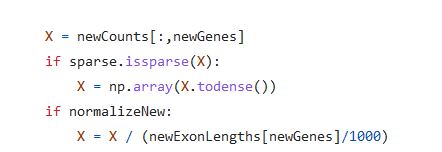

In [ ]:
norm_counts = exonCounts / (exonLengths / 1000)
log_norm_counts = np.log2(norm_counts + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].scatter(
    np.mean(log_norm_counts, axis=0),
    np.var(log_norm_counts, axis=0),
    s=10,
)
axs[0].plot(
    np.arange(0, np.max(np.mean(log_norm_counts, axis=0)), 1),
    np.arange(0, np.max(np.mean(log_norm_counts, axis=0)), 1),
    color="r",
    linewidth=2,
    label="y = x",
)

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel("Mean Expression")
axs[0].set_ylabel("Expression Variance")
axs[0].set_title("Gene variance vs mean expression")
axs[0].tick_params(which="minor", length=1, color="k")
axs[0].tick_params(which="major", length=5, color="k")
axs[0].legend()


# add plot
axs[1].scatter(
    np.mean(log_norm_counts, axis=0),
    np.var(log_norm_counts, axis=0) / np.mean(log_norm_counts, axis=0),
    s=10,
)

axs[1].plot(
    np.arange(0, np.max(np.mean(log_norm_counts, axis=0)), 1),
    np.ones(np.arange(0, np.max(np.mean(log_norm_counts, axis=0)), 1).size),
    color="r",
    linewidth=2,
    label="Model: F = 1",
)

axs[1].set_xlabel("Mean Expression")
axs[1].set_ylabel("Fano Factor")
axs[1].set_title("Normalized Counts: Fano Factor vs Mean Expression")
axs[1].set_ylim(0.01, 20)
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].tick_params(which="minor", length=2, color="k")
axs[1].tick_params(which="major", length=5, color="k")
axs[1].legend()

In [ ]:
depth_median = np.median(depth)
norm_factor = depth_median * (1 / depth)

norm_counts = norm_factor[:, np.newaxis] * exonCounts
# norm_counts = exonCounts / (exonLengths / 1000)
log_norm_counts = np.log2(norm_counts + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].scatter(
    np.mean(log_norm_counts, axis=0),
    np.var(log_norm_counts, axis=0),
    s=10,
)
axs[0].plot(
    np.arange(0, np.max(np.mean(log_norm_counts, axis=0)), 1),
    np.arange(0, np.max(np.mean(log_norm_counts, axis=0)), 1),
    color="r",
    linewidth=2,
    label="y = x",
)

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel("Mean Expression")
axs[0].set_ylabel("Expression Variance")
axs[0].set_title("Gene variance vs mean expression")
axs[0].tick_params(which="minor", length=1, color="k")
axs[0].tick_params(which="major", length=5, color="k")
axs[0].legend()


# add plot
axs[1].scatter(
    np.mean(log_norm_counts, axis=0),
    np.var(log_norm_counts, axis=0) / np.mean(log_norm_counts, axis=0),
    s=10,
)

axs[1].plot(
    np.arange(0, np.max(np.mean(log_norm_counts, axis=0)), 1),
    np.ones(np.arange(0, np.max(np.mean(log_norm_counts, axis=0)), 1).size),
    color="r",
    linewidth=2,
    label="Model: F = 1",
)

axs[1].set_xlabel("Mean Expression")
axs[1].set_ylabel("Fano Factor")
axs[1].set_title("Normalized Counts: Fano Factor vs Mean Expression")
axs[1].set_ylim(0.01, 20)
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].tick_params(which="minor", length=2, color="k")
axs[1].tick_params(which="major", length=5, color="k")
axs[1].legend()

### PCA vizualization for different transformations and normalization

In [ ]:
# Perform PCA three times for each normalization: on the resulting matrix as is,
# after np.log2(X+1) transform, and after np.sqrt(X) transform

from sklearn.decomposition import PCA


Fano = np.var(log_CTF_exon_counts, axis=0) / np.mean(
    log_CTF_exon_counts, axis=0
)
Selected_genes = Fano > 5
print(np.sum(Selected_genes))
# CTF
sqrt_CTF = np.sqrt(CTF_exon_counts)

# perform PCA
pca = PCA(n_components=50)
pca_CTF = pca.fit_transform(CTF_exon_counts[:, genesForRRR])
pca_log_CTF = pca.fit_transform(log_CTF_exon_counts[:, genesForRRR])
pca_sqrt_CTF = pca.fit_transform(sqrt_CTF[:, genesForRRR])

# Gene lenght norm
Fano = np.var(log_norm_counts, axis=0) / np.mean(log_norm_counts, axis=0)
Selected_genes = Fano > 6
print(np.sum(Selected_genes))

sqrt_norm = np.sqrt(norm_counts)

# perform PCA
pca = PCA(n_components=50)
pca_norm_counts = pca.fit_transform(norm_counts[:, Selected_genes])
pca_log2__norm_counts = pca.fit_transform(log_norm_counts[:, Selected_genes])
pca_sqrt_norm_counts = pca.fit_transform(sqrt_norm[:, Selected_genes])

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(9, 6))
axs = axs.flatten()

# Plot CTF

axs[0].scatter(pca_CTF[:, 0], pca_CTF[:, 1], s=3, c=cluster_colors, alpha=0.8)
axs[0].set_title("PCA")

axs[1].scatter(
    pca_log_CTF[:, 0], pca_log_CTF[:, 1], s=3, c=cluster_colors, alpha=0.8
)
axs[1].set_title("PCA after $log_2(X+1)$")

axs[2].scatter(
    pca_sqrt_CTF[:, 0], pca_sqrt_CTF[:, 1], s=3, c=cluster_colors, alpha=0.8
)
axs[2].set_title("PCA after sqrt")

axs[3].scatter(
    pca_norm_counts[:, 0],
    pca_norm_counts[:, 1],
    s=3,
    c=cluster_colors,
    alpha=0.8,
)
axs[3].set_title("PCA")

axs[4].scatter(
    pca_log2__norm_counts[:, 0],
    pca_log2__norm_counts[:, 1],
    s=3,
    c=cluster_colors,
    alpha=0.8,
)
axs[4].set_title("PCA after $log_2(X+1)$")
axs[4].set_xlim(-50, 100)
axs[4].set_ylim(-75, 75)

axs[5].scatter(
    pca_sqrt_norm_counts[:, 0],
    pca_sqrt_norm_counts[:, 1],
    s=3,
    c=cluster_colors,
    alpha=0.8,
)
axs[5].set_title("PCA after sqrt")
axs[5].set_xlim(-300, 300)
axs[5].set_ylim(-200, 200)


fig.supxlabel("$1^{st}$ PC")
fig.supylabel("$2^{nd}$ PC")

In [ ]:
tsne = TSNE(perplexity=30)
tsne_counts = tsne.fit(pca_sqrt_norm_counts)
fig, axs = plt.subplots()
axs.scatter(
    tsne_counts[:, 0], tsne_counts[:, 1], s=20, c=cluster_colors, alpha=0.8
)
axs.set_title("TSNE")
axs.set_axis_off()